**Importing necessary libraries**

In [99]:
#import all necessary libraries
import numpy as np
import pandas as pd
import itertools
import os
import nltk
import torch
from sklearn.externals import joblib
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.svm import SVC
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
layers = keras.layers
models = keras.models

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Mounting drive**

In [100]:
from google.colab import drive 
drive.mount('/content/drive') #mount the google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading the dataset from the google drive**

In [0]:
data = pd.read_csv("/content/drive/My Drive/bbc-text.csv") #read the dataset

**Printig the first 5 raw of dataset**

In [102]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


**Value counts of dataset by category**

In [103]:
data['category'].value_counts() #count the no. of data in each category

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

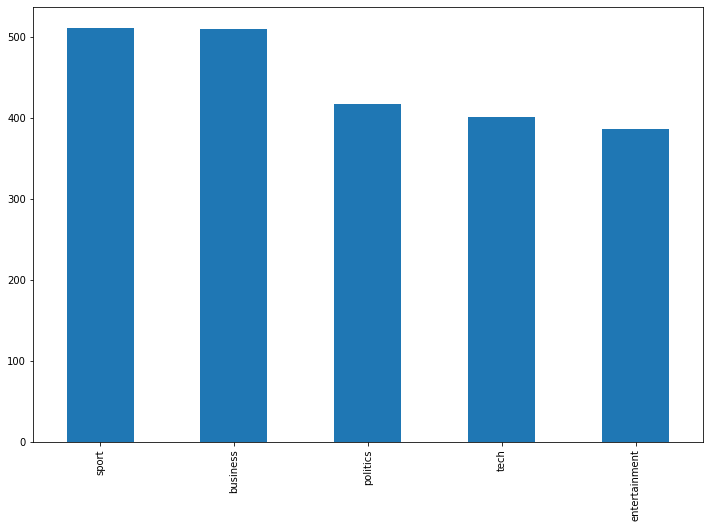

In [104]:
data['category'].value_counts().plot.bar(figsize=(12, 8)) #plot the graph from above result regarding counting the data in each  category

**Labelizing**

In [105]:
le = LabelEncoder() # Label the dataset category vise
data['labels'] = le.fit_transform(data['category'])
data.head()

,category,text,labels
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1


**Pre-processing**

In [0]:
stemmer = PorterStemmer() #use of porter stemmer
to_exclude = set(stopwords.words('english') + list(punctuation)) #removing stopwards and punctuations
filter_func = lambda text: ' '.join([stemmer.stem(word) for word in word_tokenize(text) if word not in to_exclude]) 

**You can see the pre-processed dataset**

In [107]:
data['text'] = data['text'].apply(filter_func) #applying above function
data.head()

,category,text,labels
0,tech,tv futur hand viewer home theatr system plasma...,4
1,business,worldcom boss left book alon former worldcom b...,0
2,sport,tiger wari farrel gambl leicest say rush make ...,3
3,sport,yead face newcastl fa cup premiership side new...,3
4,entertainment,ocean twelv raid box offic ocean twelv crime c...,1


**Tf-IDF Vectorization**

In [108]:
tf_vect = TfidfVectorizer(ngram_range=(1, 2)) #setting up the range of ngrams of TF-IDF vectorizer
X = tf_vect.fit_transform(data['text'].values)
y = data['labels'].values

print('X shape: {}, y shape: {}'.format(X.shape, y.shape))

X shape: (2225, 338958), y shape: (2225,)


**Train/Test Split in 70/30**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # set the train test  split

**Proposed Model**

In [110]:
svc = SVC(random_state=1) #use support vector classifier setting up random state as 1
svc.get_params() # to get the all parameters 

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [0]:
svc_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'C': np.linspace(.1, .9, 6) 
}

In [123]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) #applying gridsearch method for getting the best parameters to apply on model
grid_search_estimator = GridSearchCV(svc, svc_grid, scoring='accuracy', cv=cv, n_jobs=-1)
grid_search_estimator.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=1, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.1 , 0.26, 0.42, 0.58, 0.74, 0.9 ]),
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

grid_search_estimator.best_params_

In [124]:
print('SVM best score: {:.8f}'.format(grid_search_estimator.best_score_)) 

SVM best score: 0.97707319


**Finding and applying best parameters**

In [0]:
predicted = grid_search_estimator.best_estimator_.fit(X_train, y_train).predict(X_test) #Call predict on the estimator with the best found parameters.

**Visualize the confusion matrix**

In [126]:
print(confusion_matrix(y_test, predicted)) #confusion metrix of the model

[[155   2   5   0   0]
 [  0 110   0   0   1]
 [  0   0 115   0   0]
 [  1   0   0 155   0]
 [  0   1   0   0 123]]


In [127]:
print(classification_report(y_test, predicted)) #final output

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       162
           1       0.97      0.99      0.98       111
           2       0.96      1.00      0.98       115
           3       1.00      0.99      1.00       156
           4       0.99      0.99      0.99       124

    accuracy                           0.99       668
   macro avg       0.98      0.99      0.98       668
weighted avg       0.99      0.99      0.99       668



In [117]:
joblib.dump(grid_search_estimator.best_estimator_, 'project2.h5') #to save the model

['project2.h5']